# TP1: Data Exploration

## Winter 2023 - BIN710 Data Mining (UdeS)

First assignement as part of the Data Mining class at UdeS.

Student name : Simon Lalonde

### Directory structure

├── TP1_data.csv    ---> Data

├── tp1.ipynb   ---> Jupyter Notebook

└── TP1.pdf    ---> Tasks to complete

### Metadata
csv file with :
- 59 objects
- 4 features
- 3 classes (as factors)

### Goal
Are all 4 features relevant for a classification task. The classifier will be distance based (KNN with K=5 or nearest centroid classifier)

---

### 1. Data Representation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.stats import shapiro 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestCentroid
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import patches
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture

Read, inspect and check for inconsistencies

In [2]:
datafile = Path("TP1_data.csv")
df = pd.read_csv(datafile, index_col=0)
df.head()

,attribut1,attribut2,attribut3,attribut4,classe
id1,38.0,33.0,10.0,19.0,0
id2,38.2,23.4,17.0,16.6,0
id3,33.0,24.0,19.0,23.0,0
id4,31.0,21.0,29.0,16.0,0
id5,37.0,27.0,24.0,12.0,0


In [3]:
# Check types, NaN or negative data
print(f"Data types : {np.unique(df.dtypes.to_list())}") # types

print(f"Number of rows with any NaN : {len(df.isna().any()[df.isna().any()])}") #NaN

# Check for neg data
print(f"Number of cols with negative values : {len((df < 0).any()[(df < 0).any()].index)}") # Negative vals

Data types : [dtype('int64') dtype('float64')]
Number of rows with any NaN : 0
Number of cols with negative values : 0


In [4]:
# Extracting features
cols = df.columns.to_list()
features = cols[:-1]
print(features)

['attribut1', 'attribut2', 'attribut3', 'attribut4']


#### a) Evaluate correlations and possible transformations

Check correlations between features and then comparing between classes

In [5]:
# Check distributions
def get_distributions(data, features, plt_rows, plt_cols, feat_color=True, hue=None, bins='auto', binwidth=None, kde=True):
    # Square subplots
    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(8,10))
    axes = axes.ravel()

    for i, feat in enumerate(features):
        if feat_color:
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=sns.color_palette()[i])
        else :
            feat_color = None
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=feat_color)
        plot.set(title=f"Distribution for : {feat}")
        plot.set(xlabel="")

    fig.tight_layout()


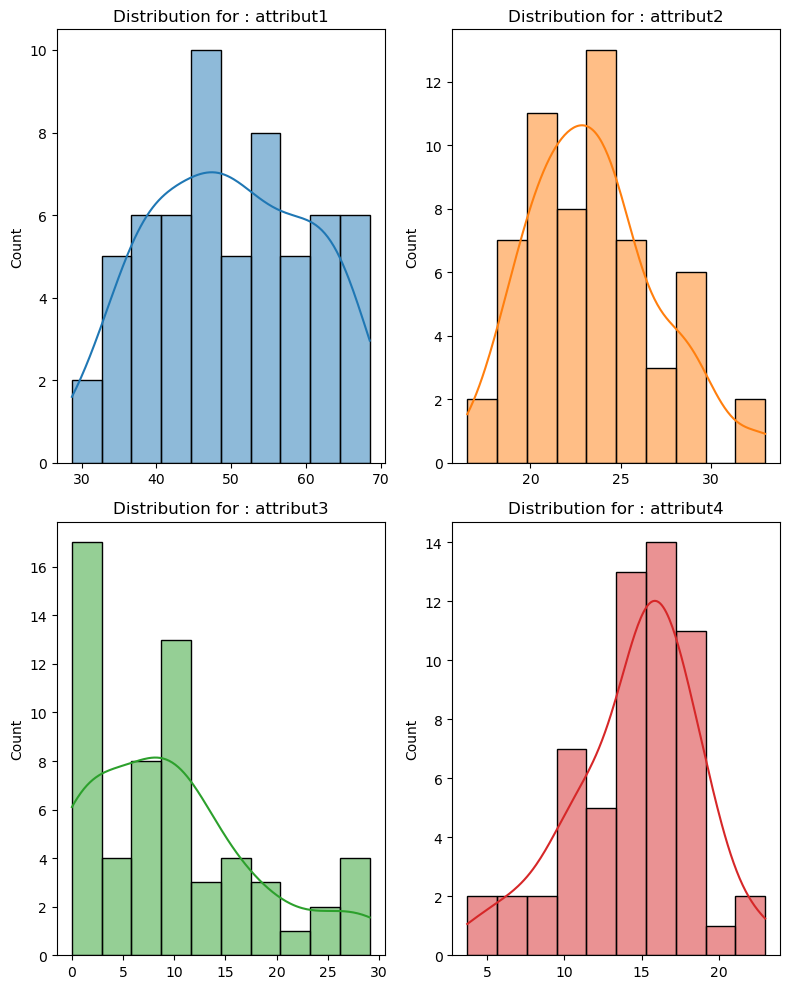

In [6]:
# Check distributions
get_distributions(df[features], features, 2, 2, bins=10, kde=True)


attribut1,2 and 4 seem normally distributed while 3 is more spread out (in kurtosis terms)

In [7]:
def check_normality(df, features):
    for feat in features:
        norm = shapiro(df[feat])
        if norm.pvalue < 0.05:
            print(f"{feat} is not normally distributed since pval={norm.pvalue} < 0.05")
        else:
            print(f"{feat} follows a normal distribution (null hypothesis)")

In [8]:
# Check for normality 
check_normality(df, features)

attribut1 follows a normal distribution (null hypothesis)
attribut2 follows a normal distribution (null hypothesis)
attribut3 is not normally distributed since pval=0.00028542501968331635 < 0.05
attribut4 follows a normal distribution (null hypothesis)


**Check dispersions measures**

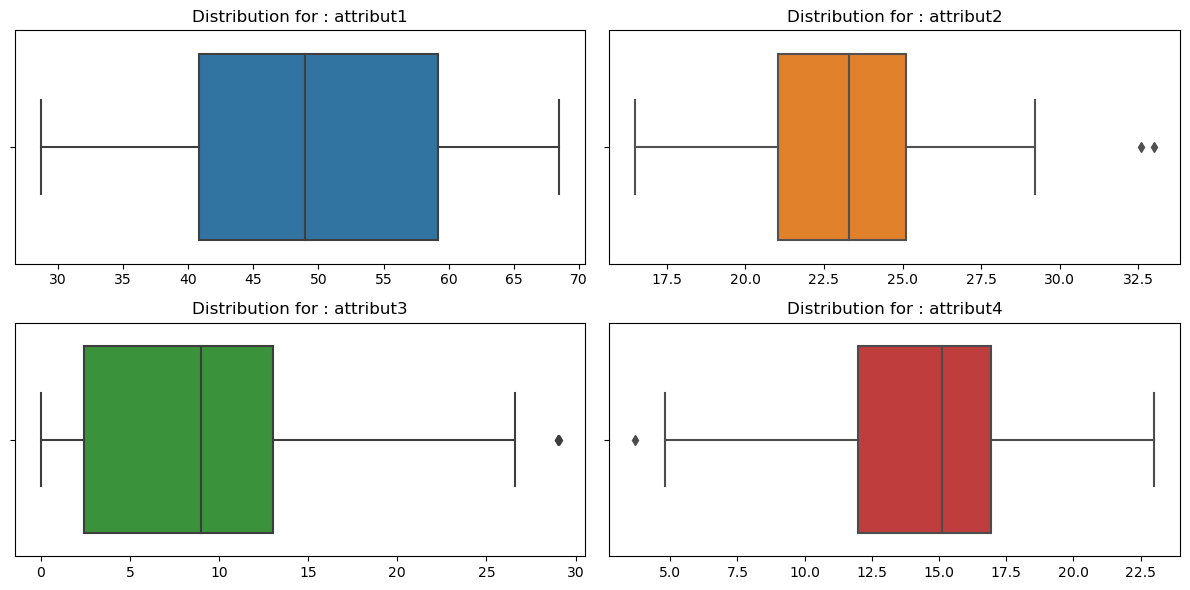

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
axes = axes.ravel()

for i, feat in enumerate(features):
    plot = sns.boxplot(data=df, x=feat, ax=axes[i], color=sns.color_palette()[i])
    plot.set(title=f"Distribution for : {feat}")
    plot.set(xlabel="")

fig.tight_layout()

<AxesSubplot: >

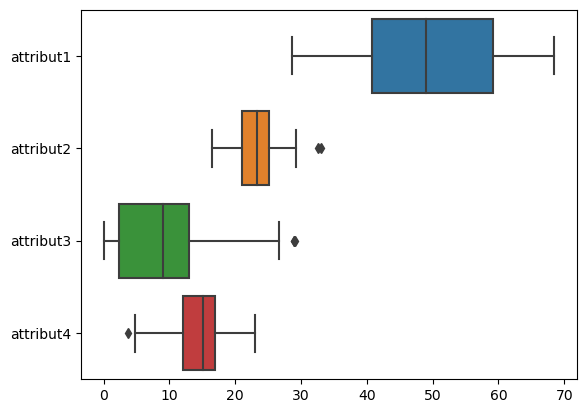

In [10]:
sns.boxplot(data=df[features], orient="h")

**Remove outliers** :

Looking at the distributions, only attr2 2x outliers seem real outliers since the others that are outside 1.5 IQR seem still part of their distribution's shape.

In [11]:
# Get indexes
outliers_index = df[df["attribut2"] > 30].index.to_list()
# Check if common outliers accross features
print(outliers_index)

['id1', 'id9']


In [12]:
# Apply filter
df = df[df["attribut2"] < 30]
len(df)

57

In [13]:
df.head(10)

,attribut1,attribut2,attribut3,attribut4,classe
id2,38.2,23.4,17.0,16.6,0
id3,33.0,24.0,19.0,23.0,0
id4,31.0,21.0,29.0,16.0,0
id5,37.0,27.0,24.0,12.0,0
id6,46.7,23.3,11.1,18.9,0
id7,36.0,18.0,29.0,12.0,0
id8,40.7,28.9,10.7,17.4,0
id10,47.0,28.0,9.0,16.0,0
id11,40.3,24.8,14.8,15.1,0
id12,43.0,24.0,15.0,16.0,0


Re-evaluate normality

In [14]:
# Check for normality 
check_normality(df, features)

attribut1 follows a normal distribution (null hypothesis)
attribut2 follows a normal distribution (null hypothesis)
attribut3 is not normally distributed since pval=0.0002902429550886154 < 0.05
attribut4 follows a normal distribution (null hypothesis)


<AxesSubplot: >

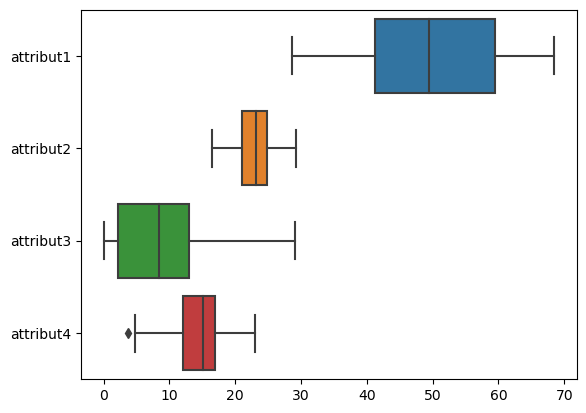

In [15]:
sns.boxplot(data=df[features], orient="h")

**Splitting into features and class**

In [16]:
# Features
X = df[features]
y = df["classe"]

In [17]:
X.head()

,attribut1,attribut2,attribut3,attribut4
id2,38.2,23.4,17.0,16.6
id3,33.0,24.0,19.0,23.0
id4,31.0,21.0,29.0,16.0
id5,37.0,27.0,24.0,12.0
id6,46.7,23.3,11.1,18.9


In [18]:
y.head()

id2    0
id3    0
id4    0
id5    0
id6    0
Name: classe, dtype: int64

In [19]:
def get_dispersions(df, features):
    for feat in features:
        mean = np.mean(df[feat])
        median = np.median(df[feat])
        sd = np.std(df[feat])
        print(f"For feature {feat} : Mean={mean:.2f}, Median={median:.2f}, Std_dev={sd:.2f}")

In [20]:
get_dispersions(X, features)

For feature attribut1 : Mean=50.22, Median=49.40, Std_dev=10.33
For feature attribut2 : Mean=23.16, Median=23.20, Std_dev=3.09
For feature attribut3 : Mean=9.56, Median=8.50, Std_dev=8.24
For feature attribut4 : Mean=14.48, Median=15.10, Std_dev=4.05


**Evaluating correlations between features**

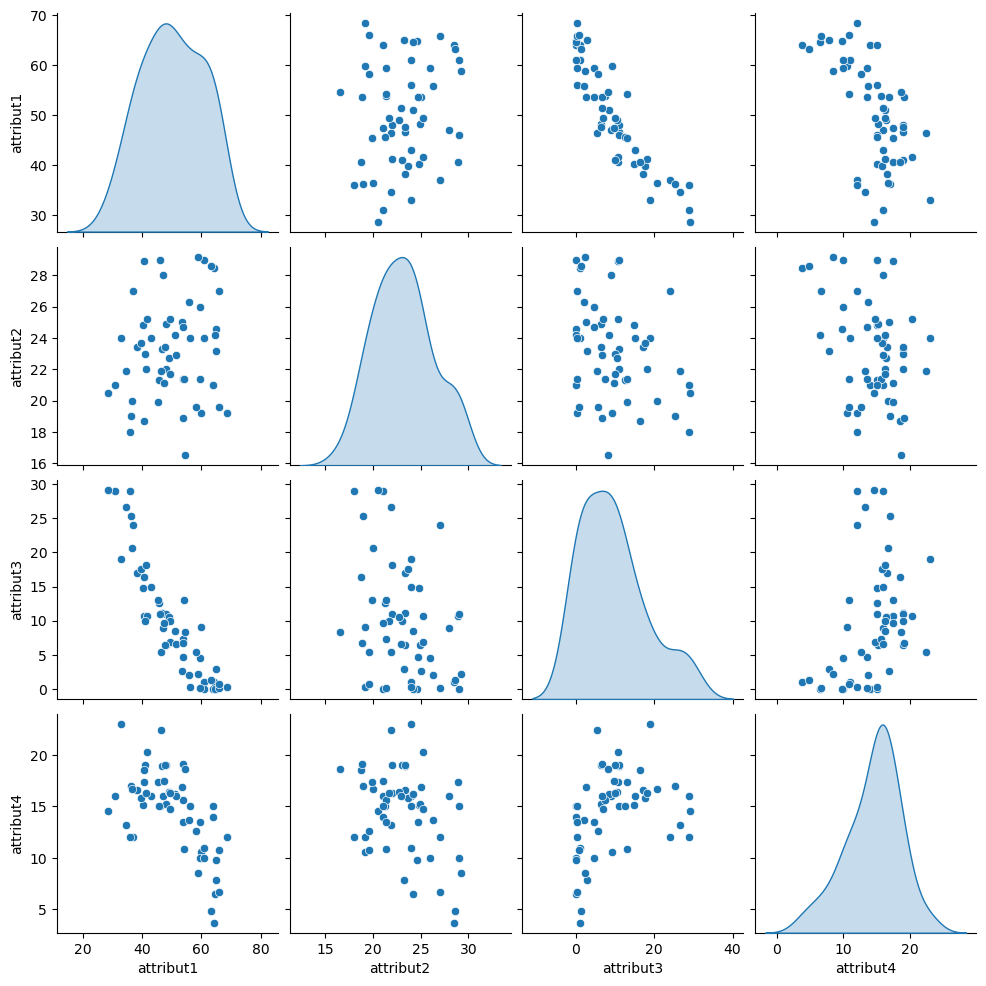

In [21]:
# Pairplot for features
g = sns.pairplot(X, diag_kind="kde")

g.tight_layout();

From the pairplot feature comparisons, we can say : 
- attribut1 and attribut3 seem inversely correlated
- attribut 1 and attribut 4 seem weakly inversely correlated 

In [22]:
# Pearson correlation
X.corr()[abs(X.corr())>0.5]

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,NaN,-0.908427,-0.621273
attribut2,NaN,1.0,NaN,NaN
attribut3,-0.908427,NaN,1.000000,NaN
attribut4,-0.621273,NaN,NaN,1.000000


In [23]:
# Check with other correlation coefficients for non-normal attribut3
X.corr(method="spearman")[abs(X.corr(method="spearman"))>0.5]

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,NaN,-0.915433,-0.600918
attribut2,NaN,1.0,NaN,NaN
attribut3,-0.915433,NaN,1.000000,NaN
attribut4,-0.600918,NaN,NaN,1.000000


Distributions for each feature per class

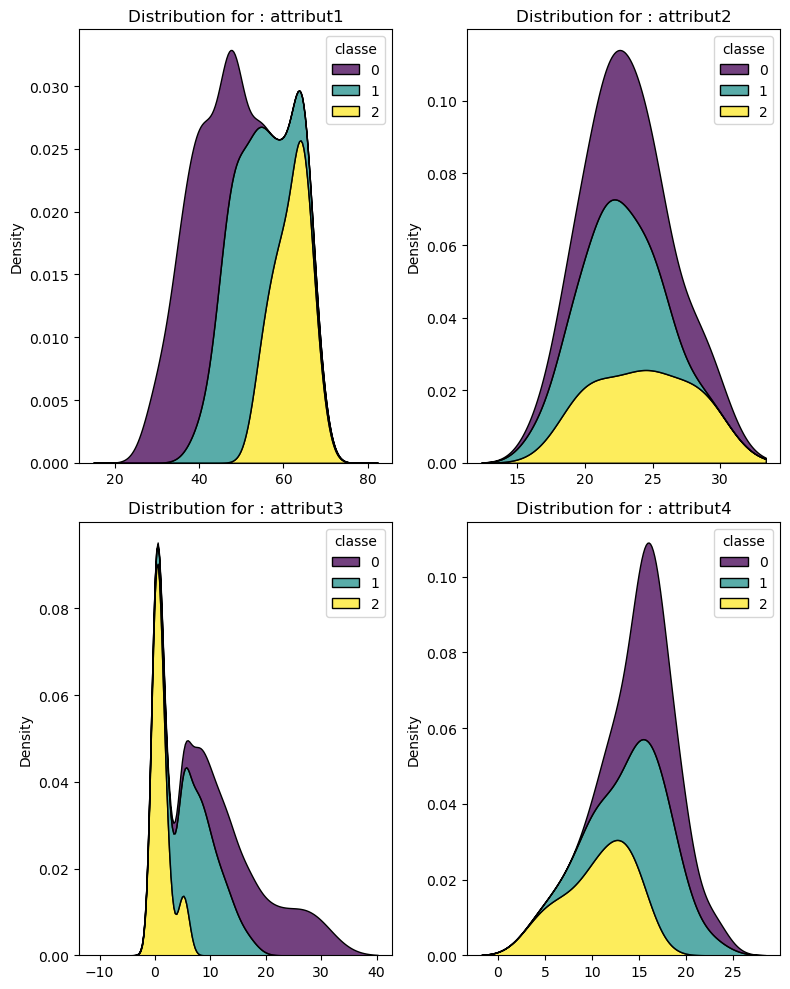

In [24]:
plt_rows = 2
plt_cols = 2

fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(8,10))
axes = axes.ravel()

for i, feat in enumerate(features):
    plot = sns.kdeplot(data=df, x=feat, ax=axes[i], hue="classe", multiple="stack", palette="viridis")
    plot.set(title=f"Distribution for : {feat}")
    plot.set(xlabel="")

fig.tight_layout()

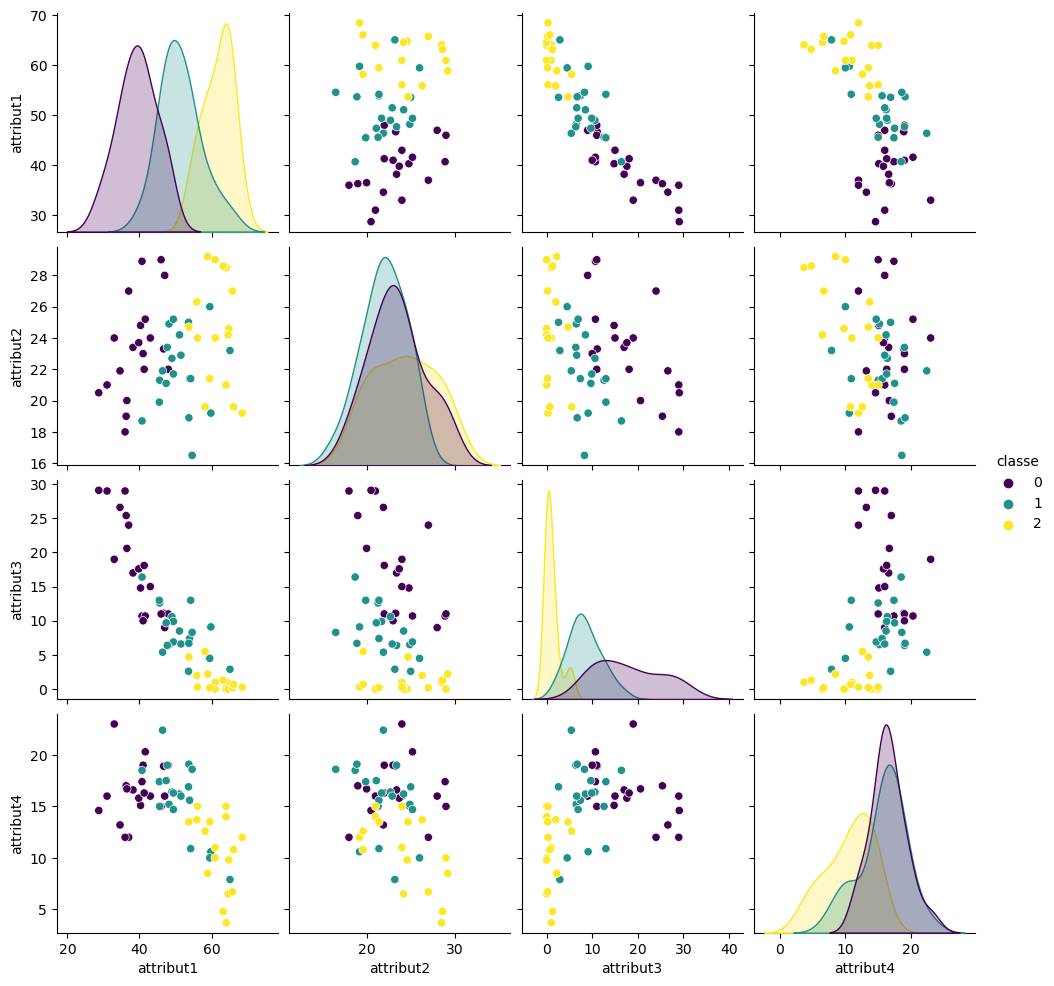

In [25]:
# Pairplot for features
g = sns.pairplot(df, diag_kind="kde", hue="classe", palette="viridis")

g.tight_layout();

#### b) Principal Component Analysis (PCA)

PCA will remove the correlation aspect between combinations of attribut1-3 and attribut1-4 and also center/rescale the data. Thus the classification model would probably benefit from PCA. 

However, since we do not have a lot of features (4D can still be visualized without dimensionality reduction) we will need to evaluate if the models will benefit from dimensionality reduction

We will perform PCA, choose a right number of components to keep and visualize the data post transformation

In [26]:
def plot_explained_variance(data, n_components):
    # Calculate cumulated variance
    model = PCA(n_components=n_components)
    cumul = []
    tot = 0
    pca = model.fit(data)
    for i in pca.explained_variance_ratio_:
        cumul.append(i+tot)
        tot += i
    # Plot
    n_compo = np.arange(1, pca.n_components_+1)
    plt.figure()
    plt.plot(n_compo, cumul, marker="o")
    plt.axhline(y=n_components, color="black", linestyle="--" )
    plt.legend(["Cumulative explained variance", f"{n_components*100}% variance threshold"])
    return pca

Number of components to keep for PCA according to Kaiser's_rule : 3


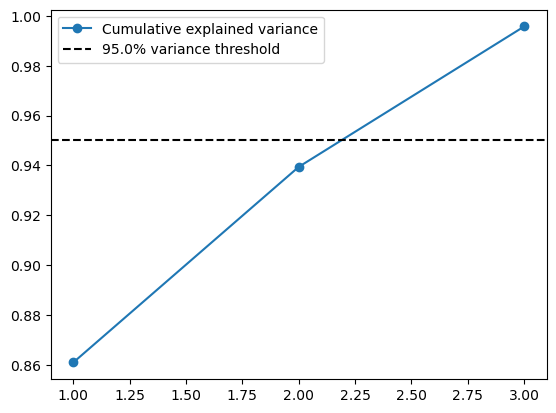

In [27]:
# 95% variance explained
# pca95 = PCA(0.95).fit(X)
pca95 = plot_explained_variance(X, 0.95)
kaiser_rule = len([i for i in (pca95.explained_variance_ > 1) if i==True])
print(f"Number of components to keep for PCA according to Kaiser's_rule : {kaiser_rule}")

Number of components to keep for PCA according to Kaiser's_rule : 3


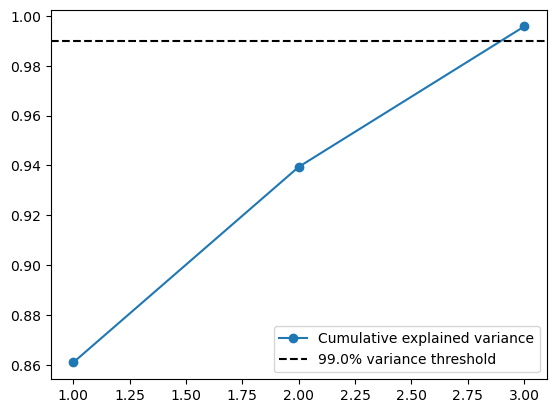

In [28]:
# 99% variance explained
pca99 = plot_explained_variance(X, 0.99)
kaiser_rule = len([i for i in (pca99.explained_variance_ > 1) if i==True])
print(f"Number of components to keep for PCA according to Kaiser's_rule : {kaiser_rule}")

- To capture 95% to 99 of the variance explained we would need 3 components
- Since the explained variance after dimension reduction to 1, 2, 3 dimension dimension are > 1 : 3 components
---

### 2. Distance Measure

Since there are some correlations between some of the features, I hypothesize that the Mahalanobis distance will be better to determine the distance between each objects in regards to its true class

#### a) Caclulate nearest centroids (using Eucledian distance) for each objects with n_components = 2 and 3 and compare with truth

In [29]:
# Fit the model for 2PCs and 3PCs
pca_2c = PCA(n_components=2).fit(X)
pca_3c = PCA(n_components=3).fit(X)

In [30]:
# Dimensionality reduction 2PCs and 3PCs
data2d = pca_2c.transform(X)
data3d = pca_3c.transform(X)
# with y as our classes

**Considering  that PCA scores are centered at zero, it means their euclidean distance to the centroid (if we don't consider the class, k=1) is basically the array itself.**

In [31]:

print(f"pca_2c centroid : {np.mean(data2d, dtype='float64')}")
print(f"pca_2c centroid : {np.mean(data3d, dtype='float64')}")

pca_2c centroid : -2.806721716640089e-15
pca_2c centroid : -2.326923579097404e-15


We can calculate the Manhattan and Euclidean distance to the centroids by :
1. grouping by class
2. calculating the mean
3. Euc = square root of the substraction the value of transformed (or not) datapoint to the mean to the power of 2 (Question 1b)
4. Man = retrieving the absolute value from the substraction of the point to the mean (Question 2a)

For PCA with 2-dimensions

In [32]:
# Get Centroids
pca2c_df = pd.DataFrame(data2d, columns=["pc1","pc2"])
pca2c_df = pca2c_df.set_index(df.index)
pca2c_df["real_class"] = y.values
pca2c_centroids = pca2c_df.groupby("real_class").mean()
pca2c_centroids

,pc1,pc2
real_class,,
0,13.831944,-0.413602
1,-1.294030,1.433810
2,-14.750487,-1.200246


In [33]:
# Euclidian/Manhattan distances to centroid class for 2PCs

# Difference to centroid
pca2c_dist = pca2c_df.groupby("real_class").transform(lambda x: (x - x.mean())).rename(columns = {"pc1" : "pc1-cent", "pc2" : "pc2-cent"})
# Manhattan dist
pca2c_dist["man"] = np.abs(pca2c_dist["pc1-cent"]) + np.abs(pca2c_dist["pc2-cent"])
# Euclidean dist
pca2c_dist["euc"] = np.sqrt(np.power(pca2c_dist["pc1-cent"], 2) + np.power(pca2c_dist["pc2-cent"], 2))
# Adding PC1, PC2 and classes back
pca2c_dist[["pc1", "pc2"]] = pca2c_df[["pc1", "pc2"]]
pca2c_dist["real_class"] = y.values
pca2c_dist.head()


,pc1-cent,pc2-cent,man,euc,pc1,pc2,real_class
id2,0.342333,0.873504,1.215837,0.938190,14.174277,0.459903,0
id3,6.697886,6.098934,12.796821,9.058625,20.529831,5.685333,0
id4,13.169791,-4.415756,17.585547,13.890367,27.001735,-4.829357,0
id5,4.449861,-6.506106,10.955966,7.882301,18.281805,-6.919707,0
id6,-9.390660,3.931193,13.321852,10.180313,4.441285,3.517591,0


In [34]:
cotest = np.cov(pca2c_df["pc1"], pca2c_df["pc2"])
cotest[0, 1]/np.sqrt(cotest[0, 0] * cotest[1, 1])
np.sqrt(1-cotest[0, 1]/np.sqrt(cotest[0, 0] * cotest[1, 1]))
np.sqrt(cotest[0, 0])

13.257685593115266

In [35]:
# Taken from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [36]:
# Extracting PCs per class for confidence ellipses
pca2c_dist[pca2c_dist["real_class"] == 0]["pc1"].head()

id2    14.174277
id3    20.529831
id4    27.001735
id5    18.281805
id6     4.441285
Name: pc1, dtype: float64

Text(0.5, 0.98, '2PCs : Euc, Man Distances and PC1/PC2 relative to class')

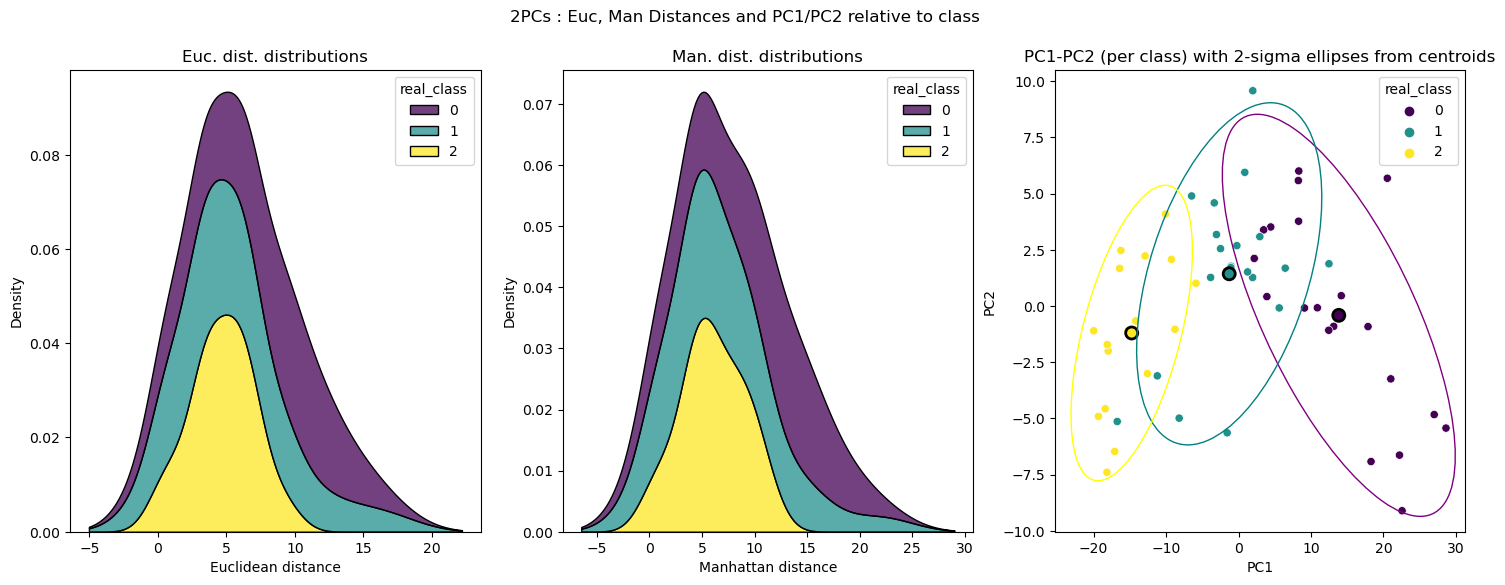

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.kdeplot(data=pca2c_dist, x="euc", hue="real_class", multiple="stack", palette="viridis", ax=axes[0])
axes[0].set_xlabel("Euclidean distance")
axes[0].set_title("Euc. dist. distributions")
sns.kdeplot(data=pca2c_dist, x="man", hue="real_class", multiple="stack", palette="viridis", ax=axes[1])
axes[1].set_xlabel("Manhattan distance")
axes[1].set_title("Man. dist. distributions")
sns.scatterplot(data=pca2c_dist, x="pc1", y="pc2", hue="real_class", palette="viridis", ax=axes[2])
sns.scatterplot(data=pca2c_centroids, x="pc1", y="pc2", hue="real_class", marker="o", linewidth=2, edgecolor="k", s=75, palette="viridis", legend=False, ax=axes[2])
confidence_ellipse(pca2c_dist[pca2c_dist["real_class"] == 0]["pc1"], pca2c_dist[pca2c_dist["real_class"] == 0]["pc2"], axes[2], edgecolor="purple")
confidence_ellipse(pca2c_dist[pca2c_dist["real_class"] == 1]["pc1"], pca2c_dist[pca2c_dist["real_class"] == 1]["pc2"], axes[2], edgecolor="teal")
confidence_ellipse(pca2c_dist[pca2c_dist["real_class"] == 2]["pc1"], pca2c_dist[pca2c_dist["real_class"] == 2]["pc2"], axes[2], edgecolor="yellow")
axes[2].set_xlabel("PC1")
axes[2].set_ylabel("PC2")
axes[2].set_title("PC1-PC2 (per class) with 2-sigma ellipses from centroids")
fig.suptitle("2PCs : Euc, Man Distances and PC1/PC2 relative to class")


Here the ellipses for the clusters are basically a covariance matrix based ellipse scaled with the std deviation of PC1 and PC2, meaning it is strongly dictated by the distribution of PC1 and PC2 per class.

If gives us an intuition about possible misclassification by using Euclidean/Manhattab distances vs using a distribution-related distance such as the Mahalanobis distance

For PCA with 3-dimensions

In [38]:
# Get Centroids
pca3c_df = pd.DataFrame(data3d, columns=["pc1","pc2", "pc3"])
pca3c_df = pca3c_df.set_index(df.index)
pca3c_df["real_class"] = y.values
pca3c_centroids = pca3c_df.groupby("real_class").mean()
pca3c_centroids

,pc1,pc2,pc3
real_class,,,
0,13.831944,-0.413602,-1.058108
1,-1.294030,1.433810,1.367128
2,-14.750487,-1.200246,-0.363552


In [39]:
# Euclidian/Manhattan distances to centroid class for 3PCs

# Difference to centroid
pca3c_dist = pca3c_df.groupby("real_class").transform(lambda x: (x - x.mean())).rename(columns = {"pc1" : "pc1-cent", "pc2" : "pc2-cent", "pc3" : "pc3-cent"})
# Manhattan dist
pca3c_dist["man"] = np.abs(pca3c_dist["pc1-cent"]) + np.abs(pca3c_dist["pc2-cent"]) + np.abs(pca3c_dist["pc3-cent"])
# Euclidean dist
pca3c_dist["euc"] = np.sqrt(np.power(pca3c_dist["pc1-cent"], 2) + np.power(pca3c_dist["pc2-cent"], 2)) + np.power(pca3c_dist["pc3-cent"], 2)
# Adding PC1, PC2 and classes back
pca3c_dist[["pc1", "pc2", "pc3"]] = pca3c_df[["pc1", "pc2", "pc3"]]
pca3c_dist["real_class"] = y.values
pca3c_dist.head()

,pc1-cent,pc2-cent,pc3-cent,man,euc,pc1,pc2,pc3,real_class
id2,0.342333,0.873504,-0.547065,1.762902,1.237471,14.174277,0.459903,-1.605173,0
id3,6.697886,6.098934,-0.712453,13.509274,9.566215,20.529831,5.685333,-1.770562,0
id4,13.169791,-4.415756,2.250284,19.835831,18.954147,27.001735,-4.829357,1.192176,0
id5,4.449861,-6.506106,-3.365352,14.321318,19.207892,18.281805,-6.919707,-4.423460,0
id6,-9.390660,3.931193,1.249852,14.571704,11.742442,4.441285,3.517591,0.191743,0


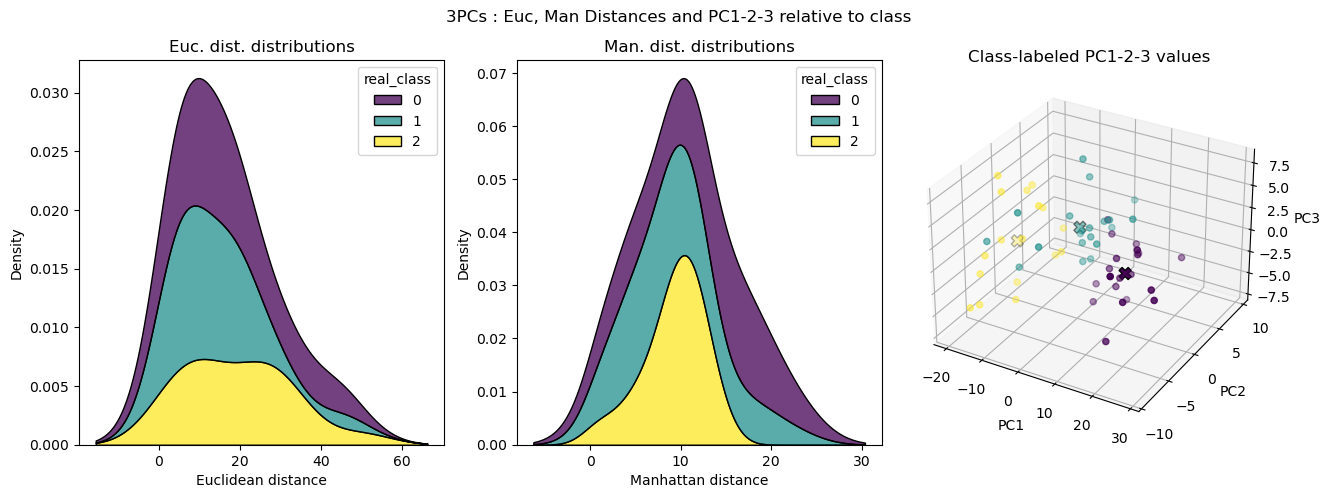

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))

sns.kdeplot(data=pca3c_dist, x="euc", hue="real_class", multiple="stack", palette="viridis", ax=axes[0])
axes[0].set_xlabel("Euclidean distance")
axes[0].set_title("Euc. dist. distributions")
sns.kdeplot(data=pca3c_dist, x="man", hue="real_class", multiple="stack", palette="viridis", ax=axes[1])
axes[1].set_xlabel("Manhattan distance")
axes[1].set_title("Man. dist. distributions")
axes[2].axis("off")
axes[2] = fig.add_subplot(1,3,3, projection="3d")
axes[2].scatter(pca3c_dist["pc1"], pca3c_dist["pc2"], pca3c_dist["pc3"], c=pca3c_dist["real_class"])
axes[2].scatter(pca3c_centroids["pc1"], pca3c_centroids["pc2"], pca3c_centroids["pc3"], c=pca3c_centroids.index, marker="X", linewidth=1, edgecolor="k", s=75)
axes[2].set_xlabel("PC1")
axes[2].set_ylabel("PC2")
axes[2].set_zlabel("PC3")
axes[2].set_title("Class-labeled PC1-2-3 values")
fig.suptitle("3PCs : Euc, Man Distances and PC1-2-3 relative to class")
box = axes[2].get_position()
box.x0 = box.x0 - 0.03
box. x1 = box.x1 - 0.03
axes[2].set_position(box)


Comparing to no transformation for with just attribut1 vs attr2-attr3-attr4

In [41]:
df_centroids = df.groupby("classe").mean()
df_centroids

,attribut1,attribut2,attribut3,attribut4
classe,,,,
0,39.335000,23.435000,17.935000,16.495000
1,51.315000,21.975000,8.350000,15.710000
2,61.729412,24.229412,1.141176,10.652941


In [42]:
features[1:]

['attribut2', 'attribut3', 'attribut4']

**There seems to be a better separation of the objects for each classes when we reduce the dimension to either 2 or 3 components. The data points seem to be further away from each other and closer to their centroids with less overlap between classes**

When we look at the look at the class-colored scatter plot (with class-centroids), we see that we might get some problems in terms of accuracy in our classification models because of covariance/correlation

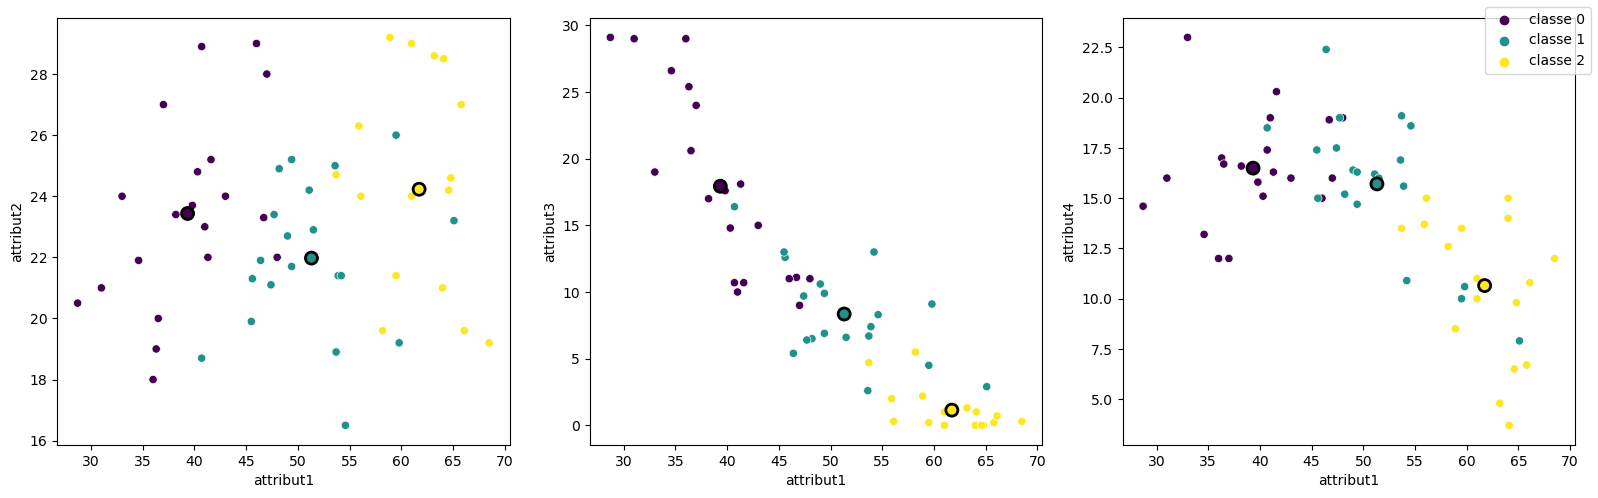

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, feat in enumerate(features[1:]):
    sns.scatterplot(data=df, x=features[0], y=feat, hue="classe", palette="viridis", ax=axes[i])
    sns.scatterplot(data=df_centroids, x=features[0], y=feat, hue="classe", marker="o", linewidth=2, edgecolor="k", s=75, palette="viridis", ax=axes[i])
    axes[i].get_legend().remove()
h, l = axes[2].get_legend_handles_labels()
fig.legend(handles=h, labels=["classe 0", "classe 1", "classe 2"], loc=1)
fig.tight_layout()



**Since we know that attribut1 has large distribution and is correlated with att3 and 4, we might benefit from using the Mahalanobis distance.** 

**Also, we see from the 2PC plot that if we use Euclidean distances later on for classification, we might get a lot of mislabeled predictions because some points of the training set might be actually closer (in Euclidean terms) to another class centroid even though they do not belong to that centroid's class. Mahalanobis distance takes into account the distribution and the correlation between variables**


 ---

#### b) Mahalanobis Distance
We want to compute the Mahalanobis distance using the covariance matrix per class since we want to get the relationship between the datapoints and their corresponding class centroid. 

We could also compute the Mahalanobis distance for all features/variables using the global means as the feature-respective centroid. This would be a good approach to build a Mahalanobis distance-based classifier.

(n_features > n_samples+1 so OK for covariance matrix calculation)

$D^2=(\boldsymbol{x}^i-\boldsymbol{x}^j)^\top\Sigma^{-1}(\boldsymbol{x}^i-\boldsymbol{x}^j)$, where $\Sigma$ is a $d\times d$ covariance matrix.

In [44]:
def per_class_mahalanobis(df, features, classif):
    # Standardize data
    X_std = df.groupby(classif).transform(lambda x: (x - x.mean()))
    
    # Covariance matrix 
    varcovar = []
    for i in range(len(features)):
        for j in range(len(features)):
            varcovar.append(np.sum((X_std.values[:, i])*(X_std.values[:, j])) / len(X-1))
    cov_mat = np.array(varcovar).reshape(len(features), len(features))
    inv_cov = np.linalg.inv(cov_mat)
    # Dot products of each terms
    lterm = np.dot(X_std, inv_cov)
    mah_dist = np.dot(lterm, X_std.T).diagonal()
    # mah_dist = np.sqrt(squared_mah_dist)
    return mah_dist

**Mahalanobis distances per class centroid for 2PC, 3PC and untransformed data**

In [45]:
# 2pc
mah_dist_2pc = per_class_mahalanobis(pca2c_df, ["pc1", "pc2"], "real_class")

In [46]:
mah_dist_3pc = per_class_mahalanobis(pca3c_df, ["pc1", "pc2", "pc3"], "real_class")

In [47]:
mah_dist_df = per_class_mahalanobis(df, features, "classe")

Outliers according to Mah distance ?

In [48]:
# check to see if some objects fall outside the critical chi-square distribution
from scipy.stats import chi2
# For outside 99% CI of chi2 dist
def get_chi2_threshold(q, degfree):
    thresh = np.sqrt(chi2.ppf(q, degfree, loc=0, scale=1))
    return thresh

print(f"{len(mah_dist_2pc[mah_dist_2pc > get_chi2_threshold(0.99, 2)])}")
print(f"{len(mah_dist_3pc[mah_dist_3pc > get_chi2_threshold(0.99, 3)])}")
print(f"{len(mah_dist_df[mah_dist_df > get_chi2_threshold(0.99, 4)])}")

16
25
31


In [49]:
pca2c_dist["mah"] = mah_dist_2pc
pca3c_dist["mah"] = mah_dist_3pc
df_dist = df.copy()
df_dist["mah"] = mah_dist_df

In [50]:
df_dist.head()

,attribut1,attribut2,attribut3,attribut4,classe,mah
id2,38.2,23.4,17.0,16.6,0,1.426802
id3,33.0,24.0,19.0,23.0,0,8.339273
id4,31.0,21.0,29.0,16.0,0,6.602691
id5,37.0,27.0,24.0,12.0,0,8.649725
id6,46.7,23.3,11.1,18.9,0,4.267396


In [51]:
pca2c_dist.head()

,pc1-cent,pc2-cent,man,euc,pc1,pc2,real_class,mah
id2,0.342333,0.873504,1.215837,0.938190,14.174277,0.459903,0,0.058816
id3,6.697886,6.098934,12.796821,9.058625,20.529831,5.685333,0,4.095316
id4,13.169791,-4.415756,17.585547,13.890367,27.001735,-4.829357,0,5.207794
id5,4.449861,-6.506106,10.955966,7.882301,18.281805,-6.919707,0,3.183841
id6,-9.390660,3.931193,13.321852,10.180313,4.441285,3.517591,0,2.966662


We could then use the Mahalanobis distance to build a classifier based on the Mah distance when/if needed later on

---

### Classification models with KNN and NearestCentroid

#### a.1) Nearest centroid model with PCA (n_components verification)

In [52]:
# Nearest centroid classifier for 2PC
clf = NearestCentroid(metric="euclidean")
ncc = clf.fit(data2d, y)
y_pred = ncc.predict(data2d)

# Using the built-in accuracy in sklearn
print(f"Mean accuracy with PCA reduction to 2-dim : {ncc.score(data2d, y)}\n")
# Or numpy np.mean(y == y_pred)

print(f"Centroids values for 2dims : \n\n{ncc.centroids_}")

Mean accuracy with PCA reduction to 2-dim : 0.8245614035087719

Centroids values for 2dims : 

[[ 13.83194411  -0.41360152]
 [ -1.29403037   1.43381048]
 [-14.75048676  -1.20024583]]


<Figure size 640x480 with 0 Axes>

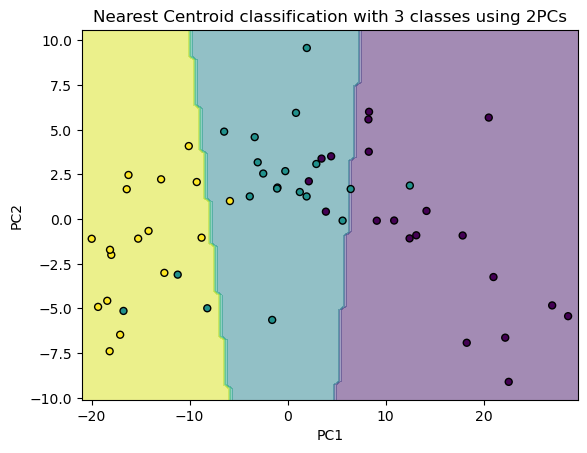

In [53]:
plt.figure()
DecisionBoundaryDisplay.from_estimator(ncc, data2d[:, :2], response_method="predict", alpha=0.5)
plt.scatter(data2d[:, 0], data2d[:,1], marker=".", s=100, c=y, edgecolors="k")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Nearest Centroid classification with 3 classes using 2PCs")
plt.show()

In [54]:
# Nearest centroid classifier for 3PC
clf = NearestCentroid(metric="euclidean")
ncc = clf.fit(data3d, y)
y_pred = ncc.predict(data3d)

# Using the built-in accuracy in sklearn
print(f"Mean accuracy with PCA reduction to 3-dim : {ncc.score(data3d, y)}\n")
# Or numpy np.mean(y == y_pred)

print(f"Centroids values for 3dims : \n\n{ncc.centroids_}")

Mean accuracy with PCA reduction to 3-dim : 0.8421052631578947

Centroids values for 3dims : 

[[ 13.83194411  -0.41360152  -1.05810836]
 [ -1.29403037   1.43381048   1.36712759]
 [-14.75048676  -1.20024583  -0.36355204]]


<Figure size 640x480 with 0 Axes>

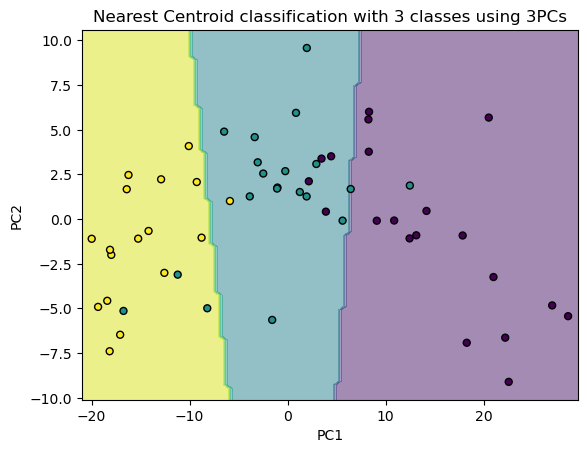

In [55]:
# for visualization of the 3PC (only first 2 PC of PCA-3dims)
clf = NearestCentroid(metric="euclidean")
ncc = clf.fit(data3d[:, :2], y)
y_pred = ncc.predict(data3d[:, :2])

plt.figure()
DecisionBoundaryDisplay.from_estimator(ncc, data3d[:, :2], response_method="predict", alpha=0.5)
plt.scatter(data3d[:, 0], data3d[:,1], marker=".", s=100, c=y, edgecolors="k")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Nearest Centroid classification with 3 classes using 3PCs")
plt.show()

Here, we see that accuracy is slightly better with n_components = 3 with PCA (the 2d representation might not show it though)

#### a.2) Splitting the data in training (70%) and test (30%) data sets
Higher proportion of test data since we don't have a lot of objects in the dataset. In theorie we could use 80/20 ratio but since our dataset is small and want to test the accuracy.

In [56]:
# Make sure we have the indices for the splitting
print("X values")
print(type(X))
print(X.head(3))
print("\n y values")
print(type(y))
print(y.head(3))

X values
<class 'pandas.core.frame.DataFrame'>
     attribut1  attribut2  attribut3  attribut4
id2       38.2       23.4       17.0       16.6
id3       33.0       24.0       19.0       23.0
id4       31.0       21.0       29.0       16.0

 y values
<class 'pandas.core.series.Series'>
id2    0
id3    0
id4    0
Name: classe, dtype: int64


In [57]:
# Setting seed to be consistent when rerunning the notebook
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [58]:
print(f"{X_train.head(3)}\n\n{y_train.head(3)}")

      attribut1  attribut2  attribut3  attribut4
id17       48.0       22.0       11.0       19.0
id34       49.0       22.7       10.6       16.4
id31       59.5       26.0        4.5       10.0

id17    0
id34    1
id31    1
Name: classe, dtype: int64


In [59]:
# Apply PCA with n_components = 3 on training and test sets
pca = PCA(n_components=3).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"X_train_pca \n{X_train_pca[:5, :]}")
print(f"y_train_pca \n {X_test_pca[:5, :]}")

X_train_pca 
[[  2.90363277  -2.81554314   2.73507717]
 [  1.3026403   -0.96466127   1.41030361]
 [-12.02573243   2.61390511  -1.56593669]
 [-19.21166982   4.08647584  -0.37662929]
 [-13.49875662   1.74762879  -5.38668887]]
y_train_pca 
 [[ -3.78379972  -3.50658791   6.57716515]
 [ -3.10568312  -2.42192765   1.29393119]
 [-16.7441619   -1.88370603   5.35549306]
 [-17.50699412   5.10999935   1.53148384]
 [ 21.35788087   7.0645733   -1.15293478]]


In [60]:
# Train the NearestCentroid model with Euclidean distance

# Setting parameters for the classifier
clf = NearestCentroid(metric="euclidean")
# Training the classifier
ncc = clf.fit(X_train_pca, y_train)
# Predict by applying the same PCA transformation to test set
y_pred = ncc.predict(X_test_pca)
print(f"Training set mean accuracy : {ncc.score(X_train_pca, y_train):.4f}")
print(f"Test set mean accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}")

Training set mean accuracy : 0.8462
Test set mean accuracy : 0.8333


In [61]:
# Per class metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.88      0.78      0.82         9
           2       1.00      0.83      0.91         6

    accuracy                           0.83        18
   macro avg       0.83      0.87      0.83        18
weighted avg       0.87      0.83      0.84        18



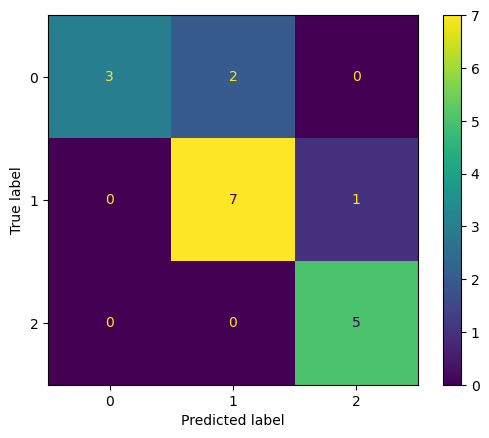

In [62]:
# As confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

#### a.3) Nearest Neighbords (with k=5) classification model

KNN with Euclidean distance

In [63]:
# KNN classifier with 3PCs using Euc

# Setting the k hyperparams + distance
neigh = KNeighborsClassifier(n_neighbors=5, metric="euclidean")

# Train the model
neigh.fit(X_train_pca, y_train)

# Predictions
y_pred = neigh.predict(X_test_pca)

print(f"Training set mean accuracy : {neigh.score(X_train_pca, y_train):.4f}")
print(f"Test set mean accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}")

Training set mean accuracy : 0.9231
Test set mean accuracy : 0.7222


In [64]:
# Per class metrics KNN-Euc
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.62      0.71      0.67         7
           2       1.00      0.71      0.83         7

    accuracy                           0.72        18
   macro avg       0.74      0.73      0.72        18
weighted avg       0.77      0.72      0.73        18



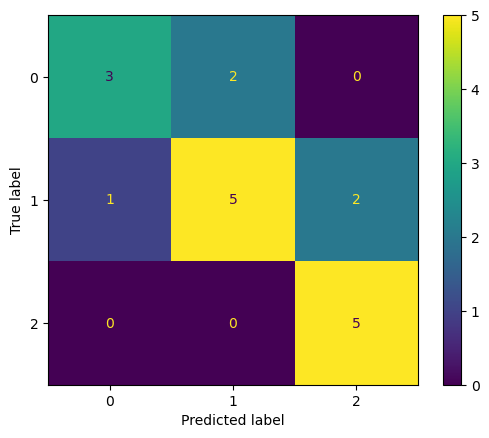

In [65]:
# Confusion matrix KNN-Euc
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

KNN with Mahalanobis distance

In [66]:
# KNN classifier with 3PCs

# Setting the k hyperparams + Mahalanobis distance
neigh_mah = KNeighborsClassifier(n_neighbors=5, metric="mahalanobis", metric_params={"V" : np.cov(X_train_pca.T)})

# Train the model
neigh_mah.fit(X_train_pca, y_train)

# Get predictions
y_pred = neigh_mah.predict(X_test_pca)

# Per class metrics
print(f"Training set mean accuracy : {neigh_mah.score(X_train_pca, y_train):.4f}")
print(f"Test set mean accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}")

Training set mean accuracy : 0.8462
Test set mean accuracy : 0.8333


In [67]:
# Per class metrics KNN-Mah
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.75      0.86      0.80         7
           2       1.00      0.71      0.83         7

    accuracy                           0.83        18
   macro avg       0.85      0.86      0.84        18
weighted avg       0.86      0.83      0.83        18



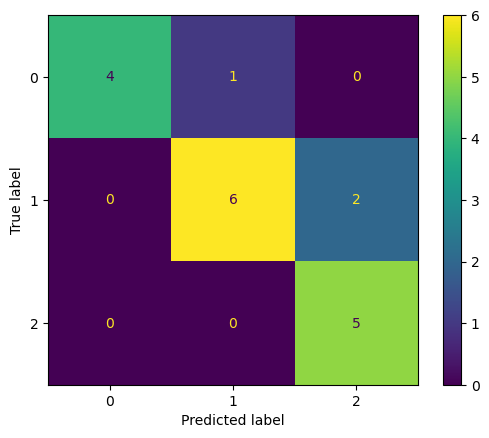

In [68]:
# As confusion matrix KNN-mah
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

**If we just look at accuracy, it seems that the best model would be the either the nearest centroid or KNN with Mahalanobis distance with both 83% accuracy**

#### b) Gaussian Mixture Model

Even though this is a supervised learning problem, let's see how many components are suggested to use in our GMM using Bayesian Information Criterion with full covariance and no dimensionality reduction

None


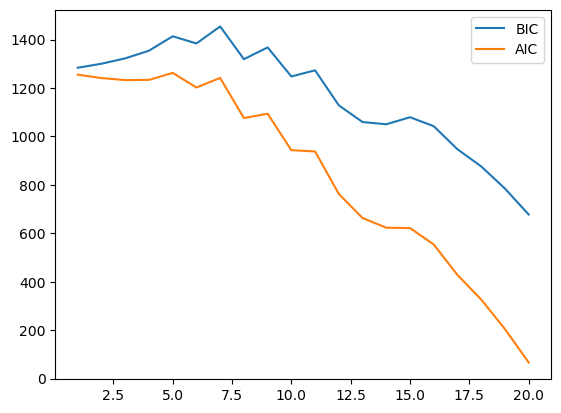

In [69]:
# BIC hyperparameter optimization 
def optimize_gmm_compo(max_compo, X):
    n_compo_range = np.arange(1,max_compo+1)
    covar_type = "full"
    gmms = [GaussianMixture(i, covariance_type="full", random_state=0).fit(X) for i in n_compo_range]
    bics = [gmm.bic(X)for gmm in gmms]
    aics = [gmm.aic(X) for gmm in gmms]
    plt.plot(n_compo_range, bics, label="BIC")
    plt.plot(n_compo_range, aics, label="AIC")    
    plt.legend()
        
print(optimize_gmm_compo(20, X))

Looking at the profile for 2PC/3PC reduced dims

None


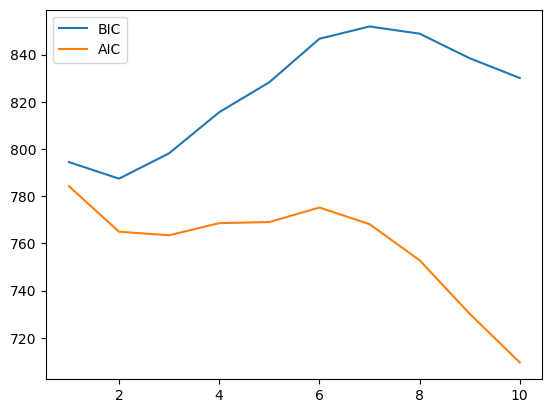

In [70]:
#2PCs BIC/AICs
print(optimize_gmm_compo(10, pca2c_df.drop(columns='real_class')))

None


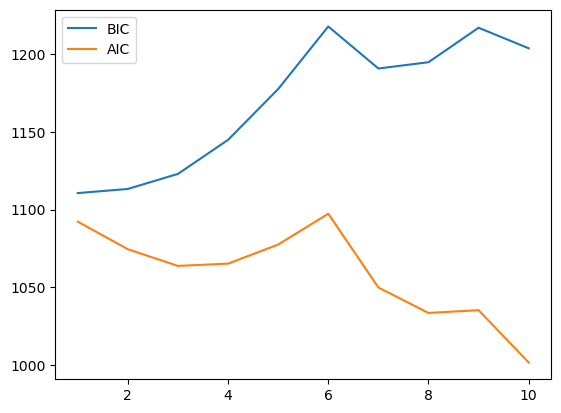

In [71]:
#3PCs BIC/AICs
print(optimize_gmm_compo(10, pca3c_df.drop(columns='real_class')))

Hyperparameter of covariance choice:
- diag = Aligns with the axes 
- spherical = Almost like euclidean distance meaning that the shape of the cluster won't represent the distributions
- full = covariance per cluster
- tied = covariance shape is the same of all clusters

I say full will give us the best model since we know looking back at the per cluster distributions of PCA-reduced data that each cluster still had different covariance per PC. Let's look at all of them and evaluate the best scoring model

In [72]:
# Gaussian Mixture Model classification for different
def gmm_models(X_train, y_train, X_test, y_test, n_compo):
    cov_types = ["diag", "spherical", "tied", "full"]
    # Set the classifiers
    gms = {}
    for cov in cov_types:
        gms[cov] = GaussianMixture(n_components=n_compo, covariance_type=cov, random_state=4, init_params="kmeans").fit(X_train, y_train)

    # Make predictions and evaluate accuracy
    for cov, gm in gms.items():
        print(f"GMM model with cov_type = {cov}")
        print(f"Has converged ? : {gm.converged_}. # iterations : {gm.n_iter_}")
        y_pred = gm.predict(X_test)
        print(f"Test set accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}\n")


In [73]:
gmm_models(X_train, y_train, X_test, y_test, 3)

GMM model with cov_type = diag
Has converged ? : True. # iterations : 9
Test set accuracy : 0.2778

GMM model with cov_type = spherical
Has converged ? : True. # iterations : 3
Test set accuracy : 0.2222

GMM model with cov_type = tied
Has converged ? : True. # iterations : 5
Test set accuracy : 0.2222

GMM model with cov_type = full
Has converged ? : True. # iterations : 10
Test set accuracy : 0.3333



In [74]:
gmm_models(X_train_pca, y_train, X_test_pca, y_test, 3)

GMM model with cov_type = diag
Has converged ? : True. # iterations : 21
Test set accuracy : 0.1667

GMM model with cov_type = spherical
Has converged ? : True. # iterations : 3
Test set accuracy : 0.2222

GMM model with cov_type = tied
Has converged ? : True. # iterations : 5
Test set accuracy : 0.2222

GMM model with cov_type = full
Has converged ? : True. # iterations : 8
Test set accuracy : 0.3333



GMM is the worst performing classifier so far regardless of the covariance type chosen. It might be explained by the fact that the models assume Gaussian distributions for the parameters. However, the model does not perform that well on the PCA-reduced data which is normally distributed which is hard to explain.

---

### 4. Application

Let's classify the new data points with the best performing model so far, KNN with Mahalanobis distance

Array to classify : [52.1, 23.0, 6.1, 16.5]

In [75]:
# Unknown data
unknown = pd.DataFrame(np.array([52.1, 23.0, 6.1, 16.5]).reshape(1, -1), columns=features)


Before performing the prediction, let's re-train our PCA and KNN model using the whole dataset

In [76]:
# Dimens-redux with PCA
pca = PCA(n_components=3).fit(X)
X_3pc = pca.transform(X)
unknown_3pc = pca.transform(unknown)

# KNN classifier with Mahalanobis distance

# Setting the k hyperparams + Mahalanobis distance
neigh_mah = KNeighborsClassifier(n_neighbors=5, metric="mahalanobis", metric_params={"V" : np.cov(X_train_pca.T)})

# Train the model
neigh_mah.fit(X_3pc, y)

# Predictions
y_pred = neigh_mah.predict(X_3pc)
unknown_pred = neigh_mah.predict(unknown_3pc)

print(f"Whole dataset mean accuracy : {metrics.accuracy_score(y, y_pred):.4f}")
print(f"Predicted class for unknown point : {unknown_pred[0]}")


Whole dataset mean accuracy : 0.8421
Predicted class for unknown point : 1


In [77]:
# DataFrame for ellipse
df_3pc = pd.DataFrame(X_3pc, columns=["pc1", "pc2", "pc3"])
df_3pc["real_class"] = y.values
df_3pc.head()

,pc1,pc2,pc3,real_class
0,14.174277,0.459903,-1.605173,0
1,20.529831,5.685333,-1.770562,0
2,27.001735,-4.829357,1.192176,0
3,18.281805,-6.919707,-4.423460,0
4,4.441285,3.517591,0.191743,0


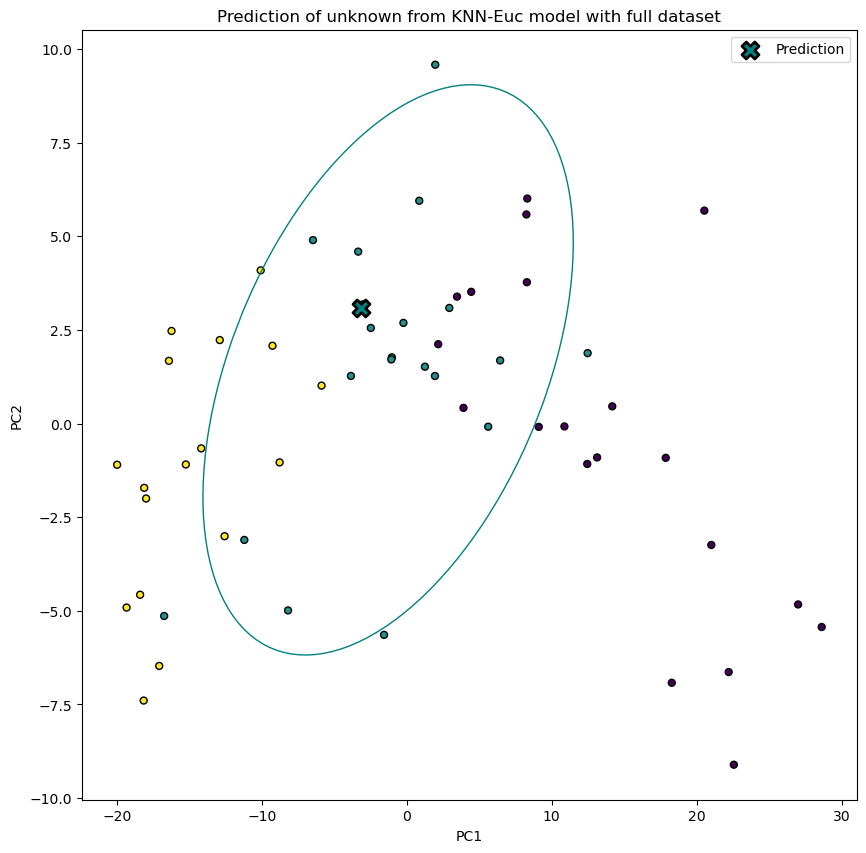

In [78]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_3pc[:, 0], X_3pc[:,1], marker=".", s=100, c=y, edgecolors="k")
ax.scatter(unknown_3pc[:, 0], unknown_3pc[:, 1], marker="X", edgecolors="k", linewidths=2, c="teal", s=150, label="Prediction")
confidence_ellipse(df_3pc[df_3pc["real_class"] == 1]["pc1"], df_3pc[df_3pc["real_class"] == 1]["pc2"], ax, edgecolor="teal")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Prediction of unknown from KNN-Euc model with full dataset")
ax.legend()